# Classification

## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

+ DESCR: 데이터셋 설명

In [2]:
print(mnist["DESCR"])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


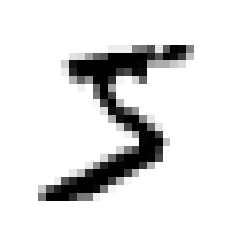

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, -1)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
import numpy as np

y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 Transfer problem to binary classification

+ 해당 그림이 5인지 아닌지 판별하는 문제로 전환

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit]) # 5로 예측함

array([ True])

## 3.3 Evaluation

### 3.3.1 Cross validation

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5): # 3 folds 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


+ 불균형 데이터 셋에서 정확도는 좋은 평가지표가 될 수 없음

In [10]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # 무조건 5는 아님으로 반환

In [11]:
never_5_clf = Never5Classifier() 
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 3.3.2 Confusion matrix

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
sgd_clf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### 3.3.3 Precision and recall

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

+ f1 score

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 Tradeoff between precision and recall 

In [18]:
sgd_clf.decision_function([some_digit]) # 0 이상이면 True

array([2164.22030239])

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions)
print(recalls)
print(thresholds)

[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]
[1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
[-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]


+ 정밀도는 못맞춘 케이스의 영향력이 커지므로 임계값이 올라도 낮아지는 경우가 있을 수 있음
+ 재현률은 부드러운 곡선

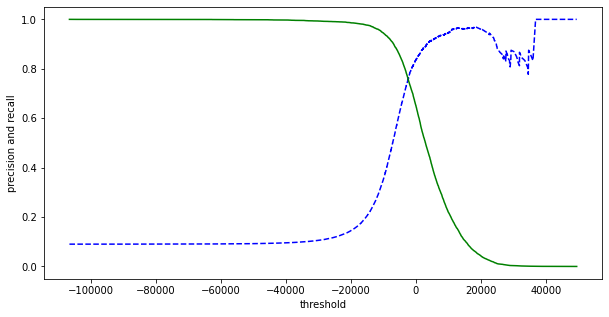

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax):
    ax.plot(thresholds, precisions[:-1], "b--", label="precision") # threshold는 점과 점사이의 구분 값이므로 하나가 적은 것에 유의
    ax.plot(thresholds, recalls[:-1], "g-", label="recall")
    ax.set_xlabel("threshold")
    ax.set_ylabel("precision and recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax=ax)
plt.show()

+ precision 90%에서 threshold를 설정

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)] # 3370.0194 (정밀도가 90%가 되는 첫번째 값을 반환)
y_train_pred_90 = y_scores >= threshold_90_precision

In [23]:
precision_score(y_train_5, y_train_pred_90) # 의도한 90%

0.9000345901072293

In [24]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

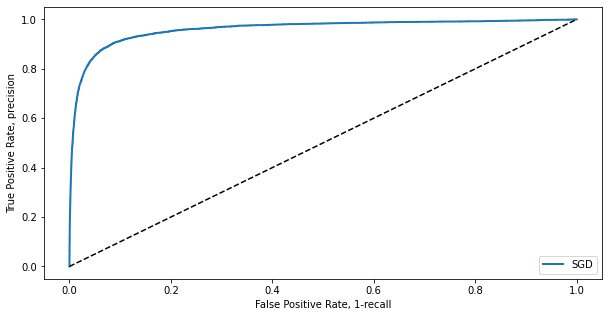

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

def plot_roc_curve(fpr, tpr, label=None, ax=ax):
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False Positive Rate, 1-recall")
    ax.set_ylabel("True Positive Rate, precision")
    ax.legend(loc="lower right")
    
plot_roc_curve(fpr, tpr, label="SGD", ax=ax)
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

+ 예측 모델로 Random Forest를 사용함

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [29]:
y_scores_rf = y_probas_forest[:, 1] # 두 클래스에 대한 확률이 모두 나오므로 positive class에 대한 score만 사용
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)

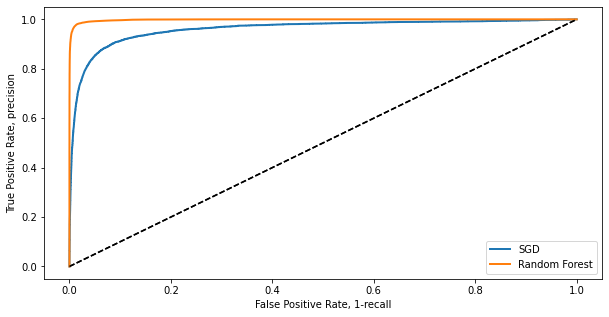

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plot_roc_curve(fpr, tpr, ax=ax, label="SGD")
plot_roc_curve(fpr_rf, tpr_rf, ax=ax, label="Random Forest")

plt.show() # Random Forest가 성능이 좋음

In [31]:
roc_auc_score(y_train_5, y_scores_rf)

0.9983436731328145

In [32]:
y_train_pred = cross_val_predict(rf_clf, X_train, y_train_5, cv=3)
print("precision:", precision_score(y_train_5, y_train_pred))
print("recall:", recall_score(y_train_5, y_train_pred))

precision: 0.9905083315756169
recall: 0.8662608374838591


## 3.4 Multiclass Classification

+ OvR(one versus the rest), OvA(one versus all): 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
+ OvO(one versus one): 각 클래스 조합마다 이진 분류기를 훈련함 

In [33]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [34]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [35]:
np.argmax(some_digit_scores)

5

In [36]:
svm_clf.classes_[5] # 가장 높은 값의 클래스

5

+ OvO나 OvR를 강제할 수 있음

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

+ SGDClassifier 훈련 예제

In [37]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [38]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

+ Improve model performance using scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## 3.5 에러 분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx